In [285]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from covid19model.models.base import BaseModel
from covid19model.data.utils import construct_initN
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.models.time_dependant_parameter_fncs import make_seasonality_function

## Define model

In [286]:
class postponed_healthcare_model(BaseModel):
    """
    Test model for postponed health_care using a waiting queue before hospitalization
    """
    
    state_names = ['W','H','R','NR']
    parameter_names = ['alpha','beta','gamma','epsilon','covid_H','dcovid_H','covid_priority']
    parameters_stratified_names = ['X','I']
    stratification = ['MDC']
    coordinates = [None]
    
    @staticmethod
    def integrate(t, W, H, R, NR, alpha, beta, gamma, epsilon, covid_H, dcovid_H, covid_priority, X, I, MDC):
        
        X_tot = sum(X)
        X = (X+W)*X_tot/sum(X+W)
        respi_idx = np.where(MDC==4)[0][0]
        X_respi = X[respi_idx] + covid_H
        X = X - X/(X_tot-X[respi_idx])*covid_priority*covid_H
        X[respi_idx] = X_respi

        dW = 1/alpha*I - 1/beta*np.where(W>(X-H),(X-H),W) - epsilon*W
        covid_H_vector = np.zeros(len(MDC))
        covid_H_vector[respi_idx] = covid_H
        dH = (1/beta*np.where(W>(X-H),(X-H),W)) - (1/gamma*(H-covid_H)) + dcovid_H
        dR = (1/gamma*(H-covid_H))
        dNR = (epsilon*W)
        
        return dW, dH, dR, dNR   

### Xi?
zonder covid geen wachtlijst dWi=0 => (X_i-H_i)=1/apha_i * I_i, neem voor H_i en I_i gemiddelde baseline
- Xtot = sum(X_i), Xtot-Xrespi = sum(X_i)-X_respi
- Wanner Covid meer I_respi: I_respi = I_respi_base + Covid_I,
- X_respi (gereserveerde plaatsen voor die ziekte) moet tijdens covid pieken hoger zijn. 
- afhankelijk van beleid meer of minder plaatsen covid reserveren => covid_priority 
- X_respi = X_respi + Covid_priority * Covid_H
- uniforme reductie van andere X_i => Xi = Xi - X_i/(X_tot-Xrespi) * Covid_priority * Covid_H
- SCENARIOS: covid_priority=0: geen covid patienten in ziekenhuis, covid_priority=0-1, extra plaatsen voorzien voor covid patienten zonder volledige opoffering van andere plaatsen (vb: veld-hospitaals of efficient omgaan met ruimtes), covid_priority=1: alle covid patienten opnemen in ziekenhuis ter opoffering van andere plaatsen, covid_priority>1 meer plaatsen in ziekenhuis voorzien dan voorspelt nodig om safety marge te hebben

## Parameters

- *alpha_i = hoeveel dagen wachten mensen om naar het ziekenhuis te gaan*
- *beta_i: = hoeveel dagen duurt het om lege plaatsen in ziekenhuis op te vullen*
- *gamma_i = hoeveel dagen lig je gemiddeld in het ziekenhuis om te recoveren*
- *1/epsilon_i = Na hoeveel  dagen in de wachtrij verlaten mensen de wachtrij door overlijden, beu zijn... wanneer 0=Niemand verlaat wachtrij*

In [287]:
# Define MDC classes to model
MDC_dict = {0:'Pre-MDC',1:'Diseases and Disorders of the Nervous System',2:'Diseases and Disorders of the Eye',3:'Diseases and Disorders of the Ear, Nose, Mouth And Throat',4:'Diseases and Disorders of the Respiratory System',5:'Diseases and Disorders of the Circulatory System'}
MDC = np.array([4,5])
respi_idx = np.where(MDC==4)[0][0]
# Define model parameters, initial states and coordinates
alpha = 1
beta = 0.1
gamma = 3
epsilon = 0.01
covid_H=0
dcovid_H=np.zeros(len(MDC))
covid_priority=1
X = np.array([60,100])
I=np.array([50,80])
#np.ones(len(MDC))*70
params={'alpha':alpha,'beta':beta,'gamma':gamma,'epsilon':epsilon,'covid_H':covid_H,'dcovid_H':dcovid_H,'covid_priority':covid_priority,'X':X,'I':I,'MDC':MDC}

# parameters that control the covid peak
start_peak = '2021-02-01'
end_peak = '2021-03-01'
peak_amplitude = 50
params.update({'start_peak':start_peak,'end_peak':end_peak,'peak_amplitude':peak_amplitude})

# parameters that control the seasonality of diseases 
amplitudes = [5, 2]
peak_shifts = [0, 5]
mean_illnesses = [10, 25] 
seasonality_function = make_seasonality_function()
params.update({'amplitudes':amplitudes,'peak_shifts':peak_shifts,'mean_illnesses':mean_illnesses,'seasonality_function':seasonality_function})

## Time dependent parameter functions

In [288]:
def I_func(t, states, param, amplitudes, peak_shifts, mean_illnesses, seasonality_function):
    res = []
    for idx,disease in enumerate(MDC):
        res.append(seasonality_function(t, states, param, amplitudes[idx], peak_shifts[idx])+mean_illnesses[idx])
    return np.transpose(res)

In [289]:

def covid_func(t, states, param,start_peak,end_peak,peak_amplitude):
    start_peak = pd.to_datetime(start_peak)
    end_peak = pd.to_datetime(end_peak)
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    # Define policies
    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0
    return covid_H


In [290]:
def dcovid_func(t, states, param,start_peak,end_peak,peak_amplitude,MDC):
    start_peak = pd.to_datetime(start_peak)
    end_peak = pd.to_datetime(end_peak)
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)
    time_interval = 0.001
    t_before = t-pd.Timedelta(days=time_interval)

    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0

    if t_before <= start_peak:
        covid_H_before = 0
    elif start_peak < t_before <= start_peak+l_days/2:
        covid_H_before = ramp_fun(0, peak_amplitude, t_before, start_peak, l/2)
    elif start_peak+l_days/2 < t_before <= end_peak:
        covid_H_before = ramp_fun(peak_amplitude, 0, t_before, start_peak+l_days/2, l/2)
    else:
        covid_H_before=0

    respi_idx = np.where(MDC==4)[0][0]
    dcovid_H = np.zeros(len(MDC))
    dcovid_H[respi_idx]=(covid_H-covid_H_before)/time_interval
    return dcovid_H


## Initialize model

In [291]:
init_states = {'H':np.ones(len(MDC))*10}
coordinates=[MDC,]
# Initialize model
model = postponed_healthcare_model(init_states,params,coordinates,time_dependent_parameters={'I': I_func,'covid_H': covid_func,'dcovid_H':dcovid_func})

## simulate model

In [292]:
#set start and end date
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-12-01')
sim_len = (end_date - start_date)/pd.Timedelta(days=1)

out = model.sim(sim_len,start_date=start_date)

159.99999999999997
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
160.00000000000003
159.99999999999997
159.99999999999997
160.00000000000003
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000

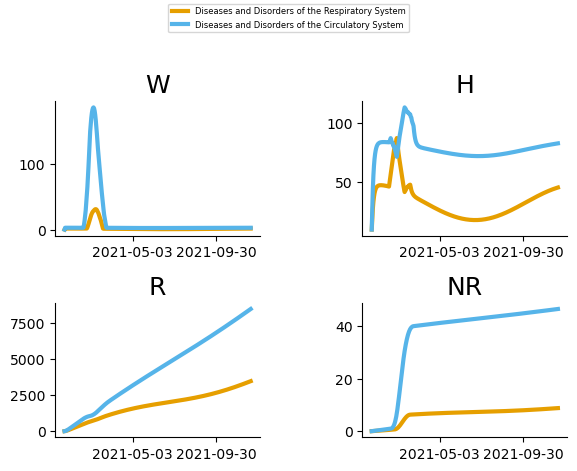

In [293]:
time = out['time']
fig, axs = plt.subplots(2,2)
axs = axs.reshape(-1)

for idx, state in enumerate(model.state_names):
    for disease in MDC:
        axs[idx].plot(time,out.sel(MDC=disease)[state], label=MDC_dict[disease])
        axs[idx].set_title(state)
        axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
        axs[idx].grid(False)
        axs[idx].tick_params(axis='both', which='major', labelsize=10)
        axs[idx].tick_params(axis='both', which='minor', labelsize=8)

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=6)
plt.show()

## with and without covid

In [294]:
model.parameters.update({'peak_amplitude':0,'epsilon':0})
out_without_covid = model.sim(sim_len,start_date=start_date)
model.parameters.update({'peak_amplitude':50,'epsilon':epsilon})
out_with_covid = model.sim(sim_len,start_date=start_date)

160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
160.00000000000003
160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
159.99999999999997
160.00000000000003
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
160.00000000000003
159.99999999999997
160.00000000000003
160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
159.99999999999997
160.00000000000003
160.00000000000003
159.99999999999997
159.99999999999997
160.00000000000003
159.99999999999997
159.99999999

KeyboardInterrupt: 

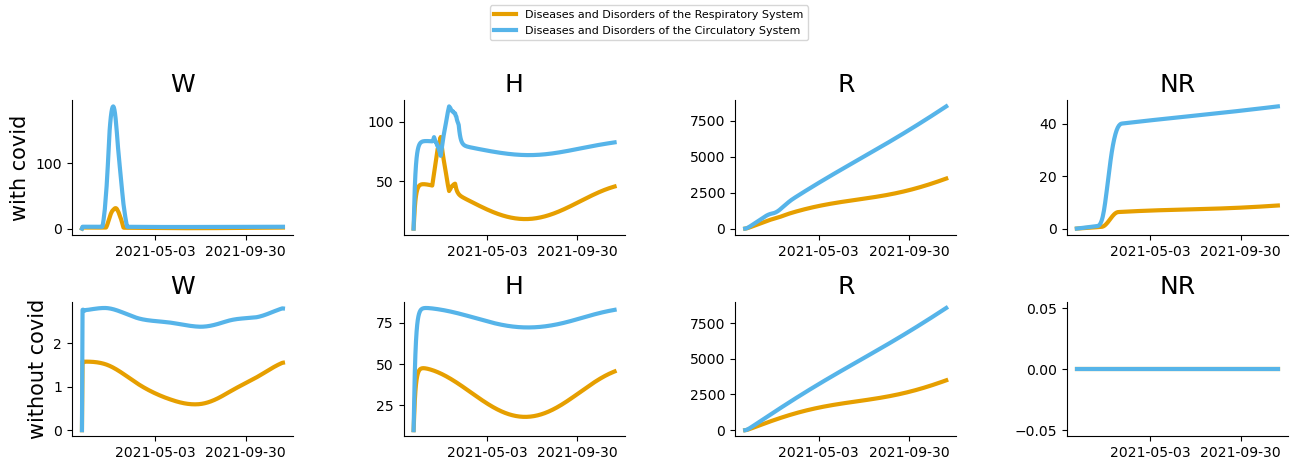

In [ ]:
fig, axs = plt.subplots(2,4)
axs = axs.reshape(-1)

idx = 0
for with_or_without in ['with','without']:
    out = globals()['out_'+with_or_without+'_covid'].copy()
    time = out['time']
    for state in model.state_names:
        for disease in MDC:
            axs[idx].plot(time,out.sel(MDC=disease)[state], label=MDC_dict[disease])
            axs[idx].set_title(state)
            axs[idx].xaxis.set_major_locator(plt.MaxNLocator(2))
            axs[idx].grid(False)
            axs[idx].tick_params(axis='both', which='major', labelsize=10)
            axs[idx].tick_params(axis='both', which='minor', labelsize=8)
        if idx==0:
            axs[idx].set_ylabel('with covid')
        elif idx==4:
            axs[idx].set_ylabel('without covid')
        idx+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=2,
                    top=0.8,
                    wspace=0.5,
                    hspace=0.5)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',fontsize=8)
plt.show()

## plot X

In [ ]:
X_plot = X
temp = X
X_tot = sum(X)
resp_idx = np.where(MDC==4)[0][0]

for t in out['time']:
    #covid func
    start_peak = pd.to_datetime(start_peak)
    end_peak = pd.to_datetime(end_peak)
    l_days = end_peak-start_peak
    l = l_days/pd.Timedelta(days=1)

    if t <= start_peak:
        covid_H = 0
    elif start_peak < t <= start_peak+l_days/2:
        covid_H = ramp_fun(0, peak_amplitude, t, start_peak, l/2)
    elif start_peak+l_days/2 < t <= end_peak:
        covid_H = ramp_fun(peak_amplitude, 0, t, start_peak+l_days/2, l/2)
    else:
        covid_H=0

    #X func
    W = out.sel(time=t)['W'].values
    temp = (temp+W)*X_tot/sum(temp+W)
    X_respi = temp[resp_idx] + covid_H
    temp = temp - temp/(X_tot-temp[resp_idx])*covid_priority*covid_H
    temp[resp_idx] = X_respi
    X_plot = np.vstack([X_plot,temp])

fig,axs = plt.subplots(len(MDC))
for idx,disease in enumerate(MDC):
    
plt.show()


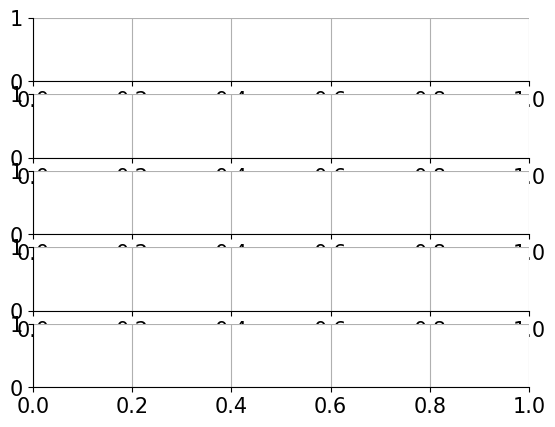

In [327]:
fig,axs = plt.subplots(5)
plt.show()